# XGBoost optimization

This script implements the feature-based classifier proposed in

Spinde, T.; Rudnitckaia, L.; Mitrović, J.; Hamborg, F.; Granitzer, M.; Gipp, B. & Donnay, K.
Automated identification of bias inducing words in news articles using linguistic and context-oriented features 
Information Processing & Management, Elsevier, 2021, 58, 102505

It will serve as baseline model to compare our system with it.

To run this script, you need the following files found in the /data directory:
- "final_labels_SG1.xlsx"
- "final_labels_SG2.xlsx"

In [1]:
# misc
import os
import re
import time
import ast
import warnings
import math
import copy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns

# data
import pandas as pd
import numpy as np
import csv

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import metrics

!pip install scikit-plot
import scikitplot as skplt
import xgboost 

## 1 Data preparation

In [42]:
data = pd.read_excel('data/dt_final_SG2.xlsx')

In [43]:
# only features and label
dt = data[[
 'sentence',
 'label4', 
 'glove_vec300_norm', 
 'tfidf_art', 
 'negative_conc',
 'positive_conc',
 'weak_subj',
 'strong_subj',
 'hyperbolic_terms',
 'attitude_markers',
 'kill_verbs',
 'bias_lexicon',
 'assertive_verbs',
 'factive_verbs',
 'report_verbs',
 'implicative_verbs',
 'hedges',
 'boosters',
 'affect ',
 'posemo ',
 'negemo ',
 'anx ',
 'anger ',
 'sad ',
 'social ',
 'family ',
 'friend ',
 'female ',
 'male ',
 'cogproc ',
 'insight ',
 'cause ',
 'discrep ',
 'tentat ',
 'certain ',
 'differ ',
 'percept ',
 'see ',
 'hear ',
 'feel ',
 'bio ',
 'body ',
 'health ',
 'sexual ',
 'ingest ',
 'drives ',
 'affiliation ',
 'achieve ',
 'power ',
 'reward ',
 'risk ',
 'focuspast ',
 'focuspresent ',
 'focusfuture ',
 'relativ ',
 'motion ',
 'space ',
 'time ',
 'work ',
 'leisure ',
 'home ',
 'money ',
 'relig ',
 'death ',
 'informal ',
 'swear ',
 'netspeak ',
 'assent ',
 'nonflu ',
 'filler ',
 'pos_ADJ',
 'pos_ADP',
 'pos_ADV',
 'pos_AUX',
 'pos_DET',
 'pos_INTJ',
 'pos_NOUN',
 'pos_PRON',
 'pos_PROPN',
 'pos_SCONJ',
 'pos_VERB',
 'pos_X',
 'dep_ROOT',
 'dep_acl',
 'dep_acomp',
 'dep_advcl',
 'dep_advmod',
 'dep_agent',
 'dep_amod',
 'dep_appos',
 'dep_attr',
 'dep_aux',
 'dep_auxpass',
 #'dep_case',
 'dep_cc',
 'dep_ccomp',
 'dep_compound',
 'dep_conj',
 'dep_csubj',
 'dep_dative',
 'dep_dep',
 'dep_det',
 'dep_dobj',
 'dep_expl',
 'dep_intj',
 'dep_mark',
 #'dep_meta',
 'dep_neg',
 'dep_nmod',
 'dep_npadvmod',
 'dep_nsubj',
 'dep_nsubjpass',
 'dep_nummod',
 'dep_oprd',
 'dep_parataxis',
 'dep_pcomp',
 'dep_pobj',
 'dep_poss',
 'dep_preconj',
 'dep_predet',
 'dep_prep',
 'dep_prt',
 'dep_punct',
 'dep_quantmod',
 'dep_relcl',
 'dep_xcomp',
 'ne_CARDINAL',
 'ne_DATE',
 'ne_EVENT',
 'ne_FAC',
 'ne_GPE',
 'ne_LANGUAGE',
 'ne_LAW',
 'ne_LOC',
 'ne_MONEY',
 'ne_NORP',
 'ne_ORDINAL',
 'ne_ORG',
 'ne_PERCENT',
 'ne_PERSON',
 'ne_PRODUCT',
 'ne_QUANTITY',
 'ne_TIME',
 'ne_WORK_OF_ART',
 'negative_conc_context',
 'positive_conc_context',
 'weak_subj_context',
 'strong_subj_context',
 'hyperbolic_terms_context',
 'attitude_markers_context',
 'kill_verbs_context',
 'bias_lexicon_context',
 'assertive_verbs_context',
 'factive_verbs_context',
 'report_verbs_context',
 'implicative_verbs_context',
 'hedges_context',
 'boosters_context',
 'affect _context',
 'posemo _context',
 'negemo _context',
 'anx _context',
 'anger _context',
 'sad _context',
 'social _context',
 'family _context',
 'friend _context',
 'female _context',
 'male _context',
 'cogproc _context',
 'insight _context',
 'cause _context',
 'discrep _context',
 'tentat _context',
 'certain _context',
 'differ _context',
 'percept _context',
 'see _context',
 'hear _context',
 'feel _context',
 'bio _context',
 'body _context',
 'health _context',
 'sexual _context',
 'ingest _context',
 'drives _context',
 'affiliation _context',
 'achieve _context',
 'power _context',
 'reward _context',
 'risk _context',
 'focuspast _context',
 'focuspresent _context',
 'focusfuture _context',
 'relativ _context',
 'motion _context',
 'space _context',
 'time _context',
 'work _context',
 'leisure _context',
 'home _context',
 'money _context',
 'relig _context',
 'death _context',
 'informal _context',
 'swear _context',
 'netspeak _context',
 'assent _context',
 'nonflu _context',
 'filler _context',
 'pos_ADJ_context',
 'pos_ADP_context',
 'pos_ADV_context',
 'pos_AUX_context',
 'pos_DET_context',
 'pos_INTJ_context',
 'pos_NOUN_context',
 'pos_PRON_context',
 'pos_PROPN_context',
 'pos_SCONJ_context',
 'pos_VERB_context',
 'pos_X_context',
 'dep_ROOT_context',
 'dep_acl_context',
 'dep_acomp_context',
 'dep_advcl_context',
 'dep_advmod_context',
 'dep_agent_context',
 'dep_amod_context',
 'dep_appos_context',
 'dep_attr_context',
 'dep_aux_context',
 'dep_auxpass_context',
 #'dep_case_context',
 'dep_cc_context',
 'dep_ccomp_context',
 'dep_compound_context',
 'dep_conj_context',
 'dep_csubj_context',
 'dep_dative_context',
 'dep_dep_context',
 'dep_det_context',
 'dep_dobj_context',
 'dep_expl_context',
 'dep_intj_context',
 'dep_mark_context',
 #'dep_meta_context',
 'dep_neg_context',
 'dep_nmod_context',
 'dep_npadvmod_context',
 'dep_nsubj_context',
 'dep_nsubjpass_context',
 'dep_nummod_context',
 'dep_oprd_context',
 'dep_parataxis_context',
 'dep_pcomp_context',
 'dep_pobj_context',
 'dep_poss_context',
 'dep_preconj_context',
 'dep_predet_context',
 'dep_prep_context',
 'dep_prt_context',
 'dep_punct_context',
 'dep_quantmod_context',
 'dep_relcl_context',
 'dep_xcomp_context',
 'ne_CARDINAL_context',
 'ne_DATE_context',
 'ne_EVENT_context',
 'ne_FAC_context',
 'ne_GPE_context',
 'ne_LAW_context',
 'ne_LOC_context',
 'ne_MONEY_context',
 'ne_NORP_context',
 'ne_ORDINAL_context',
 'ne_ORG_context',
 'ne_PERCENT_context',
 'ne_PERSON_context',
 'ne_PRODUCT_context',
 'ne_QUANTITY_context',
 'ne_TIME_context',
 'ne_WORK_OF_ART_context',
 'ne_LANGUAGE_context']]

In [44]:
print('Number of missing values:')
mis = (dt.isnull().sum()).to_frame()
for i, row in mis.iterrows():
    if row[0] > 0:
        print(i, row[0])

# Delete the rows with missing article text:
dt = dt.dropna(subset=['tfidf_art'])

Number of missing values:
tfidf_art 1190


In [45]:
dt.head()

,sentence,label4,glove_vec300_norm,tfidf_art,negative_conc,positive_conc,weak_subj,strong_subj,hyperbolic_terms,attitude_markers,kill_verbs,bias_lexicon,assertive_verbs,factive_verbs,report_verbs,implicative_verbs,hedges,boosters,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,...,dep_expl_context,dep_intj_context,dep_mark_context,dep_neg_context,dep_nmod_context,dep_npadvmod_context,dep_nsubj_context,dep_nsubjpass_context,dep_nummod_context,dep_oprd_context,dep_parataxis_context,dep_pcomp_context,dep_pobj_context,dep_poss_context,dep_preconj_context,dep_predet_context,dep_prep_context,dep_prt_context,dep_punct_context,dep_quantmod_context,dep_relcl_context,dep_xcomp_context,ne_CARDINAL_context,ne_DATE_context,ne_EVENT_context,ne_FAC_context,ne_GPE_context,ne_LAW_context,ne_LOC_context,ne_MONEY_context,ne_NORP_context,ne_ORDINAL_context,ne_ORG_context,ne_PERCENT_context,ne_PERSON_context,ne_PRODUCT_context,ne_QUANTITY_context,ne_TIME_context,ne_WORK_OF_ART_context,ne_LANGUAGE_context
0,"""Orange Is the New Black"" star Yael Stone is r...",0,7.128710,0.278468,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,"""Orange Is the New Black"" star Yael Stone is r...",0,7.624207,0.126985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,"""Orange Is the New Black"" star Yael Stone is r...",0,7.830023,0.134708,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,"""Orange Is the New Black"" star Yael Stone is r...",0,7.506312,0.226964,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,"""Orange Is the New Black"" star Yael Stone is r...",0,9.109019,0.303142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [46]:
len(dt['sentence'].unique())

3673

In [47]:
x = dt.drop(['label4', 'sentence'], 1)
y4 = dt[['label4']]
sentence = dt[['sentence']]

In [48]:
# train-test split
train_features, test_features, train_labels, test_labels, train_sentences, test_sentences = train_test_split(x, y4, sentence,
                                                                                                             test_size = 0.10, random_state = 42)
train_features1, val_features, train_labels1, val_labels, train_sentences1, val_sentences = train_test_split(train_features, train_labels, train_sentences,
                                                                                                             test_size = 0.10, random_state = 42)

In [49]:
feature_names = list(x.columns)

In [50]:
# matrix for XGBoost
dtrain = xgboost.DMatrix(train_features, label=train_labels, feature_names=feature_names)
dtest = xgboost.DMatrix(test_features, label=test_labels, feature_names=feature_names)
dtrain1 = xgboost.DMatrix(train_features1, label=train_labels1, feature_names=feature_names)
dval = xgboost.DMatrix(val_features, label=val_labels, feature_names=feature_names)

In [51]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print('Training Features for final model Shape:', train_features1.shape)
print('Training Labels for final model Shape:', train_labels1.shape)
print('Validation Features Shape:', val_features.shape)
print('Validation Labels Shape:', val_labels.shape)

Training Features Shape: (58168, 278)
Training Labels Shape: (58168, 1)
Testing Features Shape: (6464, 278)
Testing Labels Shape: (6464, 1)
Training Features for final model Shape: (52351, 278)
Training Labels for final model Shape: (52351, 1)
Validation Features Shape: (5817, 278)
Validation Labels Shape: (5817, 1)


## 2 Baselines

### B1: Random guesser

In [ ]:
b1_pred = pd.Series(np.random.randint(2, size=len(test_features)))

In [ ]:
print('Performance of b1, test:')
print('F1:', round(metrics.f1_score(test_labels,b1_pred),2))
print('Precision:', round(metrics.precision_score(test_labels,b1_pred),2))
print('Recall:', round(metrics.recall_score(test_labels,b1_pred),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b1_pred),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b1_pred),2))
print('Confusion matrix:\n', 
      metrics.confusion_matrix(test_labels,b1_pred).transpose())

Performance of b1, test:
F1: 0.15
Precision: 0.09
Recall: 0.45
AUC: 0.47
Accuracy: 0.49
Confusion matrix:
 [[1379  165]
 [1433  137]]


### B2: Negative sentiment lexicon

In [ ]:
b2_pred = test_features.negative_conc

In [ ]:
print('Performance of b2, test:')
print('F1:', round(metrics.f1_score(test_labels,b2_pred),2))
print('Precision:', round(metrics.precision_score(test_labels,b2_pred),2))
print('Recall:', round(metrics.recall_score(test_labels,b2_pred),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b2_pred),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b2_pred),2))
print('Confusion matrix:\n', metrics.confusion_matrix(test_labels,b2_pred).transpose())

Performance of b2, test:
F1: 0.4
Precision: 0.35
Recall: 0.47
AUC: 0.69
Accuracy: 0.86
Confusion matrix:
 [[2550  160]
 [ 262  142]]


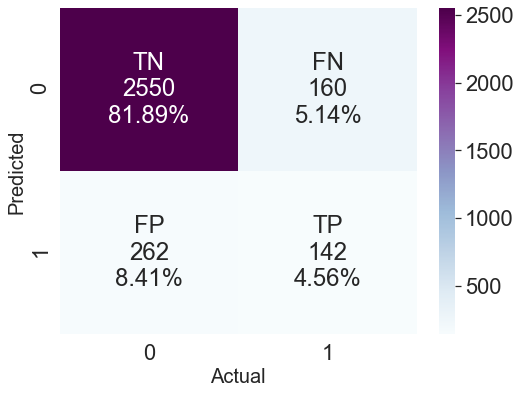

In [ ]:
cf_matrix = metrics.confusion_matrix(test_labels,b2_pred)
TN = cf_matrix[0][0]
FN = cf_matrix[1][0]
TP = cf_matrix[1][1]
FP = cf_matrix[0][1]
fl = [TN, FN, FP, TP]
fig, ax = plt.subplots(figsize=(8,6))

sns.set(font_scale=2)
group_names = ['TN','FN','FP','TP']
group_counts = ["{0:0.0f}".format(value) for value in fl]
group_percentages = ["{0:.2%}".format(value) for value in
                     fl/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="BuPu")
plt.ylabel('Predicted', fontsize=20)
plt.xlabel('Actual', fontsize=20)
ax.set_ylim([0,2])
ax.invert_yaxis()

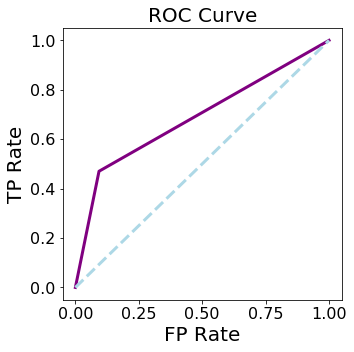

In [ ]:
plt.rcParams['font.size'] = 16
plt.subplots(1, 1, figsize=(5,5))

rand_probs = [0 for _ in range(len(test_labels))]
rand_fpr, rand_tpr, thresholds = metrics.roc_curve(test_labels, rand_probs)

fpr, tpr, thresholds = metrics.roc_curve(test_labels, b2_pred,
                                         pos_label=1)
plt.plot(fpr, tpr, linewidth=3, color='purple')
plt.plot(rand_fpr, rand_tpr, linestyle='--', linewidth=3, color='lightblue')
plt.title("ROC Curve", fontsize=20)
plt.xlabel("FP Rate", fontsize=20)
plt.ylabel("TP Rate", fontsize=20)
plt.show()

### B3: Negative and positive sentiment lexicon

In [ ]:
b3_pred = test_features.apply(lambda row: 1 if row.negative_conc==1 or row.positive_conc==1 else 0, axis=1)

In [ ]:
print('Performance of b3, test:')
print('F1:', round(metrics.f1_score(test_labels,b3_pred),2))
print('Precision:', round(metrics.precision_score(test_labels,b3_pred),2))
print('Recall:', round(metrics.recall_score(test_labels,b3_pred),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b3_pred),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b3_pred),2))
print('Confusion matrix:\n', 
      metrics.confusion_matrix(test_labels,b3_pred).transpose())

Performance of b3, test:
F1: 0.32
Precision: 0.22
Recall: 0.57
AUC: 0.68
Accuracy: 0.76
Confusion matrix:
 [[2209  129]
 [ 603  173]]


### B4: Semi-automated bias lexicon

In [ ]:
b4_pred = test_features.bias_lexicon

In [ ]:
print('Performance of b4, test:')
print('F1:', round(metrics.f1_score(test_labels,b4_pred),2))
print('Precision:', round(metrics.precision_score(test_labels,b4_pred),2))
print('Recall:', round(metrics.recall_score(test_labels,b4_pred),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b4_pred),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b4_pred),2))
print('Confusion matrix:\n', 
      metrics.confusion_matrix(test_labels,b4_pred).transpose())

Performance of b4, test:
F1: 0.2
Precision: 0.62
Recall: 0.12
AUC: 0.56
Accuracy: 0.91
Confusion matrix:
 [[2790  266]
 [  22   36]]


## 3 XGBoost optimization

In [52]:
print('Biased words:',round(len(y4[y4['label4']==1])/len(y4)*100,0),'%')
print('Neutral words:',round(len(y4[y4['label4']==0])/len(y4)*100,0),'%')

Biased words: 5.0 %
Neutral words: 95.0 %


In [53]:
def f1_eval(predt: np.ndarray, dtrain: xgboost.DMatrix):
    y = dtrain.get_label()
    predt_binary = np.where(predt > 0.5, 1, 0)
    return "F1_score", metrics.f1_score(y_true=y, y_pred=predt_binary)

### 3.1 Hyper-parameters tuning

We don't train full gridsearch, instead, we train different mutually dependent hyper-parameters together:
- max_depth & min_child_weight
- subsample & colsample_bytree
- eta

In [15]:
scale_pos_weight = len(train_labels[train_labels['label4']==0])/len(train_labels[train_labels['label4']==1])
scale_pos_weight

37.252043596730246

In [16]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':"binary:logistic",
    'disable_default_eval_metric': 1,
    'seed': 42,
    'tree_method': 'hist',
    'scale_pos_weight': scale_pos_weight
}

num_boost_round = 999

In [17]:
def f1_eval(predt: np.ndarray, dtrain: xgboost.DMatrix):
    y = dtrain.get_label()
    predt_binary = np.where(predt > 0.5, 1, 0)
    return "F1_score", metrics.f1_score(y_true=y, y_pred=predt_binary)

In [18]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,13,1)
    for min_child_weight in range(4,41,2)
]

In [19]:
start_time = time.time()
max_f1 = float(0)
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    cv_results = xgboost.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        feval=f1_eval,
        early_stopping_rounds = 10,
        maximize=True)
    
    mean_f1 = cv_results['test-F1_score-mean'].max()
    boost_rounds = cv_results['test-F1_score-mean'].argmax()
    print("\tF1 {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, F1: {}".format(best_params[0], best_params[1], max_f1))
end_time = time.time()
print('time:', end_time - start_time)

CV with max_depth=6, min_child_weight=4
	F1 0.2101268 for 96 rounds
CV with max_depth=6, min_child_weight=6
	F1 0.21083980000000002 for 124 rounds
CV with max_depth=6, min_child_weight=8
	F1 0.19949160000000002 for 61 rounds
CV with max_depth=6, min_child_weight=10
	F1 0.2174718 for 101 rounds
CV with max_depth=6, min_child_weight=12
	F1 0.2244386 for 110 rounds
CV with max_depth=6, min_child_weight=14
	F1 0.2052088 for 64 rounds
CV with max_depth=6, min_child_weight=16
	F1 0.1985248 for 55 rounds
CV with max_depth=6, min_child_weight=18
	F1 0.21007820000000002 for 82 rounds
CV with max_depth=6, min_child_weight=20
	F1 0.2252976 for 95 rounds
CV with max_depth=6, min_child_weight=22
	F1 0.2201486 for 111 rounds
CV with max_depth=6, min_child_weight=24
	F1 0.21786700000000003 for 107 rounds
CV with max_depth=6, min_child_weight=26
	F1 0.23034980000000002 for 150 rounds
CV with max_depth=6, min_child_weight=28
	F1 0.2215456 for 116 rounds
CV with max_depth=6, min_child_weight=30
	F1 0.21

In [20]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

In [21]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11,2)]
    for colsample in [i/10. for i in range(4,11,2)]
]

In [22]:
start_time = time.time()
max_f1 = float(0)
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    cv_results = xgboost.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        feval=f1_eval,
        early_stopping_rounds = 10,
        maximize=True)
    
    mean_f1 = cv_results['test-F1_score-mean'].max()
    boost_rounds = cv_results['test-F1_score-mean'].argmax()
    print("\tF1 {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample,colsample)
print("Best params: {}, {}, F1: {}".format(best_params[0], best_params[1], max_f1))
end_time = time.time()
print('time:', end_time - start_time)

CV with subsample=1.0, colsample=1.0
	F1 0.2369604 for 63 rounds
CV with subsample=1.0, colsample=0.8
	F1 0.21881659999999997 for 66 rounds
CV with subsample=1.0, colsample=0.6
	F1 0.22173099999999998 for 72 rounds
CV with subsample=1.0, colsample=0.4
	F1 0.23385799999999998 for 73 rounds
CV with subsample=0.8, colsample=1.0
	F1 0.2181352 for 47 rounds
CV with subsample=0.8, colsample=0.8
	F1 0.2248684 for 78 rounds
CV with subsample=0.8, colsample=0.6
	F1 0.20538240000000002 for 29 rounds
CV with subsample=0.8, colsample=0.4
	F1 0.2196986 for 68 rounds
CV with subsample=0.6, colsample=1.0
	F1 0.21357379999999998 for 64 rounds
CV with subsample=0.6, colsample=0.8
	F1 0.198546 for 37 rounds
CV with subsample=0.6, colsample=0.6
	F1 0.20552739999999997 for 49 rounds
CV with subsample=0.6, colsample=0.4
	F1 0.20166119999999998 for 49 rounds
Best params: 1.0, 1.0, F1: 0.2369604
time: 269.4898133277893


In [23]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [24]:
start_time = time.time()
max_f1 = float(0)
best_params = None

for eta in [0.3, 0.2, 0.1, 0.01, 0.005]:
    print("CV with eta={}".format(eta))

    params['eta'] = eta

    cv_results = xgboost.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            feval=f1_eval,
            early_stopping_rounds = 10,
            maximize=True)

    mean_f1 = cv_results['test-F1_score-mean'].max()
    boost_rounds = cv_results['test-F1_score-mean'].argmax()
    print("\tF1 {} for {} rounds\n".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta
print("Best params: {}, F1: {}".format(best_params, max_f1))
end_time = time.time()
print('time:', end_time - start_time)

CV with eta=0.3
	F1 0.2369604 for 63 rounds

CV with eta=0.2
	F1 0.2158298 for 47 rounds

CV with eta=0.1
	F1 0.21139420000000003 for 80 rounds

CV with eta=0.01
	F1 0.1259794 for 3 rounds

CV with eta=0.005
	F1 0.12478040000000001 for 7 rounds

Best params: 0.3, F1: 0.2369604
time: 77.85641241073608


In [25]:
params['eta'] = best_params

### 3.2 Final model training and evaluation

In [54]:
# optimized hyper-parameters
params = {'max_depth': 10,
 'min_child_weight': 20,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'binary:logistic',
 'disable_default_eval_metric': 1,
 'seed': 42,
 'tree_method': 'hist',
 'scale_pos_weight': scale_pos_weight}
num_boost_round=999

In [55]:
xgboost_tuned_weighted = xgboost.train(
    params,
    dtrain1,
    num_boost_round=num_boost_round,
    evals=[(dtrain1, 'dtrain'), (dval, 'dval')],
    feval=f1_eval,
    early_stopping_rounds = 10,
    maximize=True)

[0]	dtrain-F1_score:0.17689	dval-F1_score:0.154396
Multiple eval metrics have been passed: 'dval-F1_score' will be used for early stopping.

Will train until dval-F1_score hasn't improved in 10 rounds.
[1]	dtrain-F1_score:0.192269	dval-F1_score:0.16851
[2]	dtrain-F1_score:0.204314	dval-F1_score:0.174334
[3]	dtrain-F1_score:0.214406	dval-F1_score:0.17945
[4]	dtrain-F1_score:0.221137	dval-F1_score:0.183658
[5]	dtrain-F1_score:0.22793	dval-F1_score:0.187067
[6]	dtrain-F1_score:0.237969	dval-F1_score:0.193626
[7]	dtrain-F1_score:0.243109	dval-F1_score:0.195581
[8]	dtrain-F1_score:0.250195	dval-F1_score:0.201098
[9]	dtrain-F1_score:0.252304	dval-F1_score:0.202542
[10]	dtrain-F1_score:0.255241	dval-F1_score:0.202899
[11]	dtrain-F1_score:0.261164	dval-F1_score:0.209059
[12]	dtrain-F1_score:0.268079	dval-F1_score:0.214095
[13]	dtrain-F1_score:0.271151	dval-F1_score:0.213189
[14]	dtrain-F1_score:0.274423	dval-F1_score:0.213272
[15]	dtrain-F1_score:0.277637	dval-F1_score:0.216266
[16]	dtrain-F1_

In [ ]:
# xgboost_tuned_weighted.save_model("xgboost_tuned_weighted.model")
# xgboost_tuned_weighted = xgboost.Booster()
# xgboost_tuned_weighted.load_model("xgboost_tuned_weighted.model")

In [56]:
xgboost_tuned_weighted_predt = np.where(xgboost_tuned_weighted.predict(dtest) > 0.5, 1, 0)
print('Performance of xgboost_tuned_weighted, test:')
print('F1:', round(metrics.f1_score(dtest.get_label(),xgboost_tuned_weighted_predt),2))
print('Precision:', round(metrics.precision_score(dtest.get_label(), xgboost_tuned_weighted_predt),2))
print('Recall:', round(metrics.recall_score(dtest.get_label(), xgboost_tuned_weighted_predt),2))
print('AUC:', round(metrics.roc_auc_score(dtest.get_label(), xgboost_tuned_weighted_predt),2))
print('Accuracy:', round(metrics.accuracy_score(dtest.get_label(), xgboost_tuned_weighted_predt),2))
print('Confusion matrix:\n', 
      metrics.confusion_matrix(dtest.get_label(), xgboost_tuned_weighted_predt).transpose())

Performance of xgboost_tuned_weighted, test:
F1: 0.32
Precision: 0.22
Recall: 0.62
AUC: 0.75
Accuracy: 0.86
Confusion matrix:
 [[5377  127]
 [ 750  210]]


In [57]:
test_sentences['pred'] = xgboost_tuned_weighted_predt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
len(test_sentences['sentence'].unique())

2957

In [59]:
# count how many words per sentence are predicted as biased
test_sentences_hat = test_sentences.groupby('sentence', as_index=False).agg({'pred': 'sum'})
print('Number of predicted biased words per sentence:\n',test_sentences_hat['pred'].value_counts())

# rule: if one ore more bias words are in a sentence, the sentence will be labelled as biased
test_sentences_hat['Label_bias_hat'] = test_sentences_hat['pred'].apply(lambda x: 1 if x > 0 else 0)
print('Prediction on the sentence level:\n', test_sentences_hat['Label_bias_hat'].value_counts())

Number of predicted biased words per sentence:
 0    2122
1     723
2     100
3      11
4       1
Name: pred, dtype: int64
Prediction on the sentence level:
 0    2122
1     835
Name: Label_bias_hat, dtype: int64


In [60]:
# load ground-truth labels on the sentence level
#PATH_sg1 = "data/final_labels_SG1.xlsx"
PATH_sg2 = "data/final_labels_SG2.xlsx"
#sentences_ground_truth = pd.read_excel(PATH_sg1)
sentences_ground_truth = pd.read_excel(PATH_sg2)
sentences_ground_truth.rename(columns={'text': 'sentence', 'label_bias': 'Label_bias'}, inplace=True)
sentences_ground_truth = sentences_ground_truth[sentences_ground_truth['Label_bias']!='No agreement']
sentences_ground_truth.replace(to_replace='Biased', value=1, inplace=True)
sentences_ground_truth.replace(to_replace='Non-biased', value=0, inplace=True)

sentences_ground_truth = test_sentences_hat.merge(right=sentences_ground_truth, how='left', on='sentence')
sentences_ground_truth = sentences_ground_truth[sentences_ground_truth['Label_bias'].isna() == False]
sentences_ground_truth 

,sentence,pred,Label_bias_hat,news_link,outlet,topic,type,Label_bias,label_opinion,biased_words
0,'Pandemic Apprentice': Deprived of rallies to ...,1,1,https://www.alternet.org/2020/04/pandemic-appr...,Alternet,gun control,left,1.0,Somewhat factual but also opinionated,"['ego', 'muscles', 'in']"
1,"...immigrants as criminals and eugenics, all o...",1,1,https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,1.0,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
2,...we sounded the alarm in the early months of...,0,0,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,1.0,Somewhat factual but also opinionated,[]
3,A 10-hour hearing broadcast on the court’s web...,0,0,https://www.foxnews.com/sports/olympic-swimmin...,Fox News,sport,right,0.0,Somewhat factual but also opinionated,[]
4,A 16-time NBA All Star who is considered one o...,0,0,https://www.reuters.com/article/us-usa-electio...,Reuters,black lives matter,center,0.0,Entirely factual,[]
...,...,...,...,...,...,...,...,...,...,...
2952,"“He won because the Election was Rigged,” Trum...",1,1,https://www.reuters.com/article/us-usa-electio...,Reuters,vaccine,NaN,0.0,Entirely factual,[]
2953,“I would shut it down; I would listen to the s...,0,0,https://thefederalist.com/2020/08/22/biden-i-w...,Federalist,vaccine,NaN,0.0,Entirely factual,[]
2954,“Mike Pence and the task force have done a gre...,0,0,https://www.reuters.com/article/us-health-coro...,Reuters,vaccine,NaN,0.0,Entirely factual,[]
2955,“She will be inheriting a government in crisis...,2,1,https://www.breitbart.com/politics/2020/01/23/...,Breitbart,marriage-equality,NaN,1.0,Somewhat factual but also opinionated,[]


In [61]:
# compute performance
print('Performance of xgboost_tuned_weighted, test:')
print('F1:', round(metrics.f1_score(sentences_ground_truth['Label_bias'],sentences_ground_truth['Label_bias_hat']),2))
print('Precision:', round(metrics.precision_score(sentences_ground_truth['Label_bias'],sentences_ground_truth['Label_bias_hat']),2))
print('Recall:', round(metrics.recall_score(sentences_ground_truth['Label_bias'],sentences_ground_truth['Label_bias_hat']),2))
print('AUC:', round(metrics.roc_auc_score(sentences_ground_truth['Label_bias'],sentences_ground_truth['Label_bias_hat']),2))
print('Accuracy:', round(metrics.accuracy_score(sentences_ground_truth['Label_bias'],sentences_ground_truth['Label_bias_hat']),2))
print('Confusion matrix:\n', 
      metrics.confusion_matrix(sentences_ground_truth['Label_bias'],sentences_ground_truth['Label_bias_hat']).transpose())

Performance of xgboost_tuned_weighted, test:
F1: 0.45
Precision: 0.61
Recall: 0.35
AUC: 0.57
Accuracy: 0.57
Confusion matrix:
 [[1192  929]
 [ 329  506]]


In [62]:
# the same as above, but using 5-fold CV

from sklearn.model_selection import StratifiedKFold

# Stratified k-Fold instance
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k = 1
val_acc = []
val_f1 = []
val_f1_micro = []
val_f1_wmacro = []
val_recall = []
val_precision = []

for train_index, val_index in skfold.split(x,y4):

  train_features = x.iloc[train_index]
  val_features = x.iloc[val_index]
  train_labels = y4.iloc[train_index]
  val_labels = y4.iloc[val_index]
  val_sentences = sentence.iloc[val_index]
  
  dtrain = xgboost.DMatrix(train_features, label=train_labels, feature_names=feature_names)
  dval = xgboost.DMatrix(val_features, label=val_labels, feature_names=feature_names)

  xgboost_tuned_weighted = xgboost.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'dtrain'), (dval, 'dval')],
    feval=f1_eval,
    early_stopping_rounds = 10,
    maximize=True)
  
  xgboost_tuned_weighted_predt = np.where(xgboost_tuned_weighted.predict(dval) > 0.5, 1, 0)
  
  val_sentences['pred'] = xgboost_tuned_weighted_predt
  val_sentences_hat = val_sentences.groupby('sentence', as_index=False).agg({'pred': 'sum'})
  val_sentences_hat['Label_bias_hat'] = val_sentences_hat['pred'].apply(lambda x: 1 if x > 0 else 0)

  #PATH_sg1 = "data/final_labels_SG1.xlsx"
  PATH_sg2 = "data/final_labels_SG2.xlsx"
  #sentences_ground_truth = pd.read_excel(PATH_sg1)
  sentences_ground_truth = pd.read_excel(PATH_sg2)
  sentences_ground_truth.rename(columns={'text': 'sentence', 'label_bias': 'Label_bias'}, inplace=True)
  sentences_ground_truth = sentences_ground_truth[sentences_ground_truth['Label_bias']!='No agreement']
  sentences_ground_truth.replace(to_replace='Biased', value=1, inplace=True)
  sentences_ground_truth.replace(to_replace='Non-biased', value=0, inplace=True)

  sentences_merged = val_sentences_hat.merge(right=sentences_ground_truth, how='left', on='sentence')
  sentences_merged = sentences_merged[sentences_merged['Label_bias']!=99]
  sentences_merged = sentences_merged[sentences_merged['Label_bias'].isna() == False]

  val_f1.append(metrics.f1_score(sentences_merged['Label_bias'],sentences_merged['Label_bias_hat']))
  val_f1_micro.append(metrics.f1_score(sentences_merged['Label_bias'],sentences_merged['Label_bias_hat'], average='micro'))
  val_f1_wmacro.append(metrics.f1_score(sentences_merged['Label_bias'],sentences_merged['Label_bias_hat'], average='weighted'))
  val_precision.append(metrics.precision_score(sentences_merged['Label_bias'],sentences_merged['Label_bias_hat']))
  val_recall.append(metrics.recall_score(sentences_merged['Label_bias'],sentences_merged['Label_bias_hat']))
  val_acc.append(metrics.accuracy_score(sentences_merged['Label_bias'],sentences_merged['Label_bias_hat']))

  k += 1

[0]	dtrain-F1_score:0.185492	dval-F1_score:0.174846
Multiple eval metrics have been passed: 'dval-F1_score' will be used for early stopping.

Will train until dval-F1_score hasn't improved in 10 rounds.
[1]	dtrain-F1_score:0.199749	dval-F1_score:0.185264
[2]	dtrain-F1_score:0.223744	dval-F1_score:0.205913
[3]	dtrain-F1_score:0.212149	dval-F1_score:0.193831
[4]	dtrain-F1_score:0.228156	dval-F1_score:0.206642
[5]	dtrain-F1_score:0.239009	dval-F1_score:0.21365
[6]	dtrain-F1_score:0.237706	dval-F1_score:0.209025
[7]	dtrain-F1_score:0.241821	dval-F1_score:0.211009
[8]	dtrain-F1_score:0.247102	dval-F1_score:0.213636
[9]	dtrain-F1_score:0.251	dval-F1_score:0.216532
[10]	dtrain-F1_score:0.257378	dval-F1_score:0.220201
[11]	dtrain-F1_score:0.260933	dval-F1_score:0.220479
[12]	dtrain-F1_score:0.265238	dval-F1_score:0.224179
[13]	dtrain-F1_score:0.268141	dval-F1_score:0.226126
[14]	dtrain-F1_score:0.270988	dval-F1_score:0.227931
[15]	dtrain-F1_score:0.273575	dval-F1_score:0.22973
[16]	dtrain-F1_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0]	dtrain-F1_score:0.188333	dval-F1_score:0.177471
Multiple eval metrics have been passed: 'dval-F1_score' will be used for early stopping.

Will train until dval-F1_score hasn't improved in 10 rounds.
[1]	dtrain-F1_score:0.199504	dval-F1_score:0.186568
[2]	dtrain-F1_score:0.210004	dval-F1_score:0.195818
[3]	dtrain-F1_score:0.216116	dval-F1_score:0.197286
[4]	dtrain-F1_score:0.218308	dval-F1_score:0.198624
[5]	dtrain-F1_score:0.222539	dval-F1_score:0.201429
[6]	dtrain-F1_score:0.227079	dval-F1_score:0.202958
[7]	dtrain-F1_score:0.232686	dval-F1_score:0.206738
[8]	dtrain-F1_score:0.237953	dval-F1_score:0.211117
[9]	dtrain-F1_score:0.242922	dval-F1_score:0.212868
[10]	dtrain-F1_score:0.25007	dval-F1_score:0.217795
[11]	dtrain-F1_score:0.251385	dval-F1_score:0.218112
[12]	dtrain-F1_score:0.258018	dval-F1_score:0.223003
[13]	dtrain-F1_score:0.262002	dval-F1_score:0.226624
[14]	dtrain-F1_score:0.264712	dval-F1_score:0.227282
[15]	dtrain-F1_score:0.269323	dval-F1_score:0.23055
[16]	dtrain-F

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0]	dtrain-F1_score:0.177686	dval-F1_score:0.163757
Multiple eval metrics have been passed: 'dval-F1_score' will be used for early stopping.

Will train until dval-F1_score hasn't improved in 10 rounds.
[1]	dtrain-F1_score:0.199238	dval-F1_score:0.184434
[2]	dtrain-F1_score:0.208453	dval-F1_score:0.188619
[3]	dtrain-F1_score:0.222643	dval-F1_score:0.197641
[4]	dtrain-F1_score:0.225017	dval-F1_score:0.201036
[5]	dtrain-F1_score:0.232165	dval-F1_score:0.20636
[6]	dtrain-F1_score:0.239013	dval-F1_score:0.210564
[7]	dtrain-F1_score:0.242874	dval-F1_score:0.212672
[8]	dtrain-F1_score:0.244876	dval-F1_score:0.212412
[9]	dtrain-F1_score:0.249144	dval-F1_score:0.215367
[10]	dtrain-F1_score:0.25561	dval-F1_score:0.218684
[11]	dtrain-F1_score:0.257372	dval-F1_score:0.218224
[12]	dtrain-F1_score:0.264382	dval-F1_score:0.224728
[13]	dtrain-F1_score:0.268186	dval-F1_score:0.226045
[14]	dtrain-F1_score:0.268593	dval-F1_score:0.226324
[15]	dtrain-F1_score:0.273795	dval-F1_score:0.230154
[16]	dtrain-F

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0]	dtrain-F1_score:0.207346	dval-F1_score:0.182696
Multiple eval metrics have been passed: 'dval-F1_score' will be used for early stopping.

Will train until dval-F1_score hasn't improved in 10 rounds.
[1]	dtrain-F1_score:0.21705	dval-F1_score:0.190837
[2]	dtrain-F1_score:0.218327	dval-F1_score:0.190686
[3]	dtrain-F1_score:0.227499	dval-F1_score:0.198023
[4]	dtrain-F1_score:0.2325	dval-F1_score:0.201871
[5]	dtrain-F1_score:0.232854	dval-F1_score:0.202006
[6]	dtrain-F1_score:0.242185	dval-F1_score:0.206935
[7]	dtrain-F1_score:0.244372	dval-F1_score:0.206042
[8]	dtrain-F1_score:0.24887	dval-F1_score:0.209804
[9]	dtrain-F1_score:0.251333	dval-F1_score:0.212961
[10]	dtrain-F1_score:0.256235	dval-F1_score:0.214466
[11]	dtrain-F1_score:0.258991	dval-F1_score:0.216778
[12]	dtrain-F1_score:0.268372	dval-F1_score:0.222132
[13]	dtrain-F1_score:0.271346	dval-F1_score:0.224486
[14]	dtrain-F1_score:0.275773	dval-F1_score:0.226548
[15]	dtrain-F1_score:0.280586	dval-F1_score:0.231419
[16]	dtrain-F1_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[0]	dtrain-F1_score:0.180742	dval-F1_score:0.163859
Multiple eval metrics have been passed: 'dval-F1_score' will be used for early stopping.

Will train until dval-F1_score hasn't improved in 10 rounds.
[1]	dtrain-F1_score:0.204446	dval-F1_score:0.183066
[2]	dtrain-F1_score:0.211604	dval-F1_score:0.18507
[3]	dtrain-F1_score:0.217064	dval-F1_score:0.190097
[4]	dtrain-F1_score:0.222204	dval-F1_score:0.192127
[5]	dtrain-F1_score:0.229536	dval-F1_score:0.197821
[6]	dtrain-F1_score:0.231997	dval-F1_score:0.200405
[7]	dtrain-F1_score:0.239714	dval-F1_score:0.206752
[8]	dtrain-F1_score:0.245945	dval-F1_score:0.209623
[9]	dtrain-F1_score:0.247903	dval-F1_score:0.211837
[10]	dtrain-F1_score:0.255474	dval-F1_score:0.215209
[11]	dtrain-F1_score:0.260382	dval-F1_score:0.217725
[12]	dtrain-F1_score:0.261667	dval-F1_score:0.218803
[13]	dtrain-F1_score:0.267333	dval-F1_score:0.2212
[14]	dtrain-F1_score:0.27201	dval-F1_score:0.225385
[15]	dtrain-F1_score:0.274843	dval-F1_score:0.226475
[16]	dtrain-F1_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [63]:
print('5-Fold CV Accuracy: {}'.format(np.mean(val_acc)))
print('5-Fold CV Precision: {}'.format(np.mean(val_precision)))
print('5-Fold CV Recall: {}'.format(np.mean(val_recall)))
print('5-Fold CV F1 Score: {}'.format(np.mean(val_f1)))
print('5-Fold CV Micro F1 Score: {}'.format(np.mean(val_f1_micro)))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(np.mean(val_f1_wmacro)))

5-Fold CV Accuracy: 0.5752034584111635
5-Fold CV Precision: 0.5850374705136172
5-Fold CV Recall: 0.4656210665882594
5-Fold CV F1 Score: 0.5167320797219815
5-Fold CV Micro F1 Score: 0.5752034584111635
5-Fold CV Weighted Macro F1 Score: 0.5692833727914473
